# Analyzing Neural Time Series Data: Chapter 11

#### Converted from MATLAB to Python by Andrew J. Graves on 01/08/20

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from mpl_toolkits.mplot3d import Axes3D # For 3d visualization
plt.rc('font', size=8)

# Run data extraction and useful function script; double quotes work for Windows and Mac paths
%run "data_and_funcs.ipynb"

### Figure 11.1

<IPython.core.display.Javascript object>


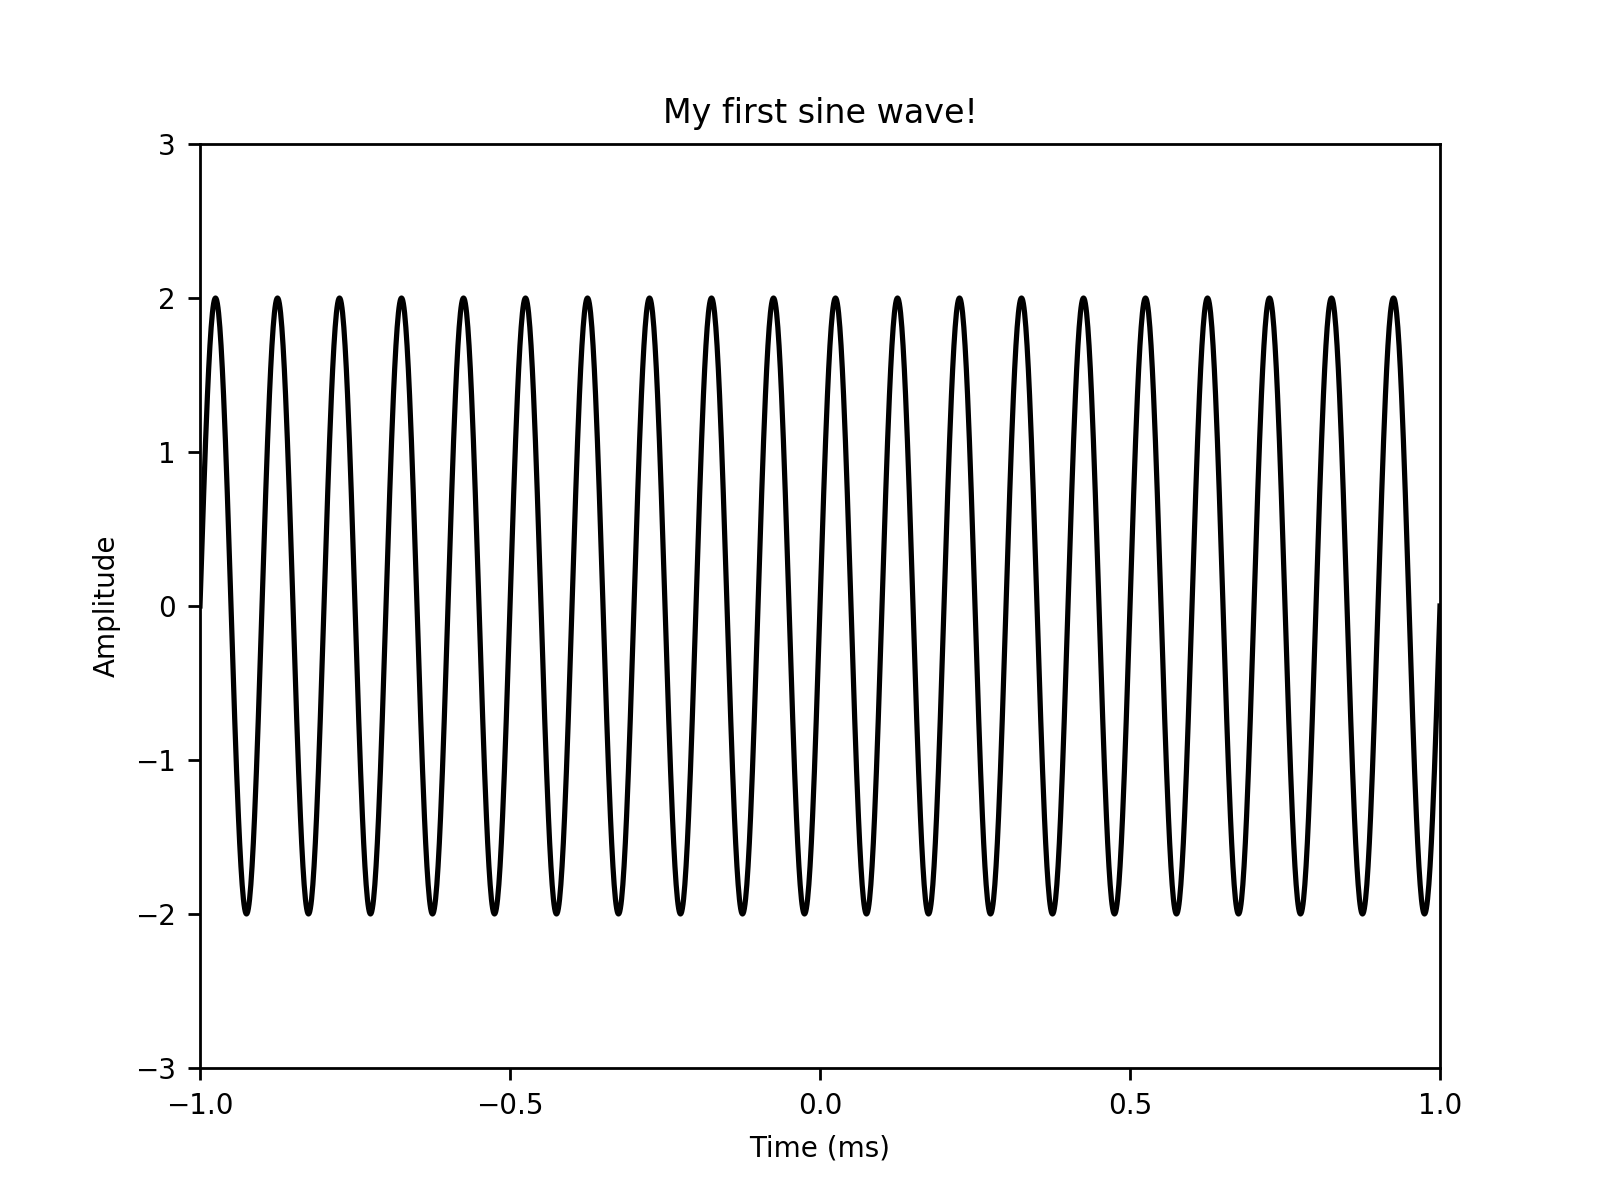

In [2]:
# Get matplotlib magick
%matplotlib notebook

srate = 1000 # sampling rate in Hz
time = np.arange(-1, 1 + 1/srate, 1/srate)
freq = 10 # in Hz
amp = 2 # amplitude or height of the sine wave

sine_wave = get_sine_wave(freq, amp, time)

plt.plot(time, sine_wave, color='black')
plt.xlim([-1, 1])
plt.ylim([-3, 3])
plt.xticks(np.arange(-1, 1.5, .5))
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('My first sine wave!')
plt.show()

### Figure 11.2

<IPython.core.display.Javascript object>


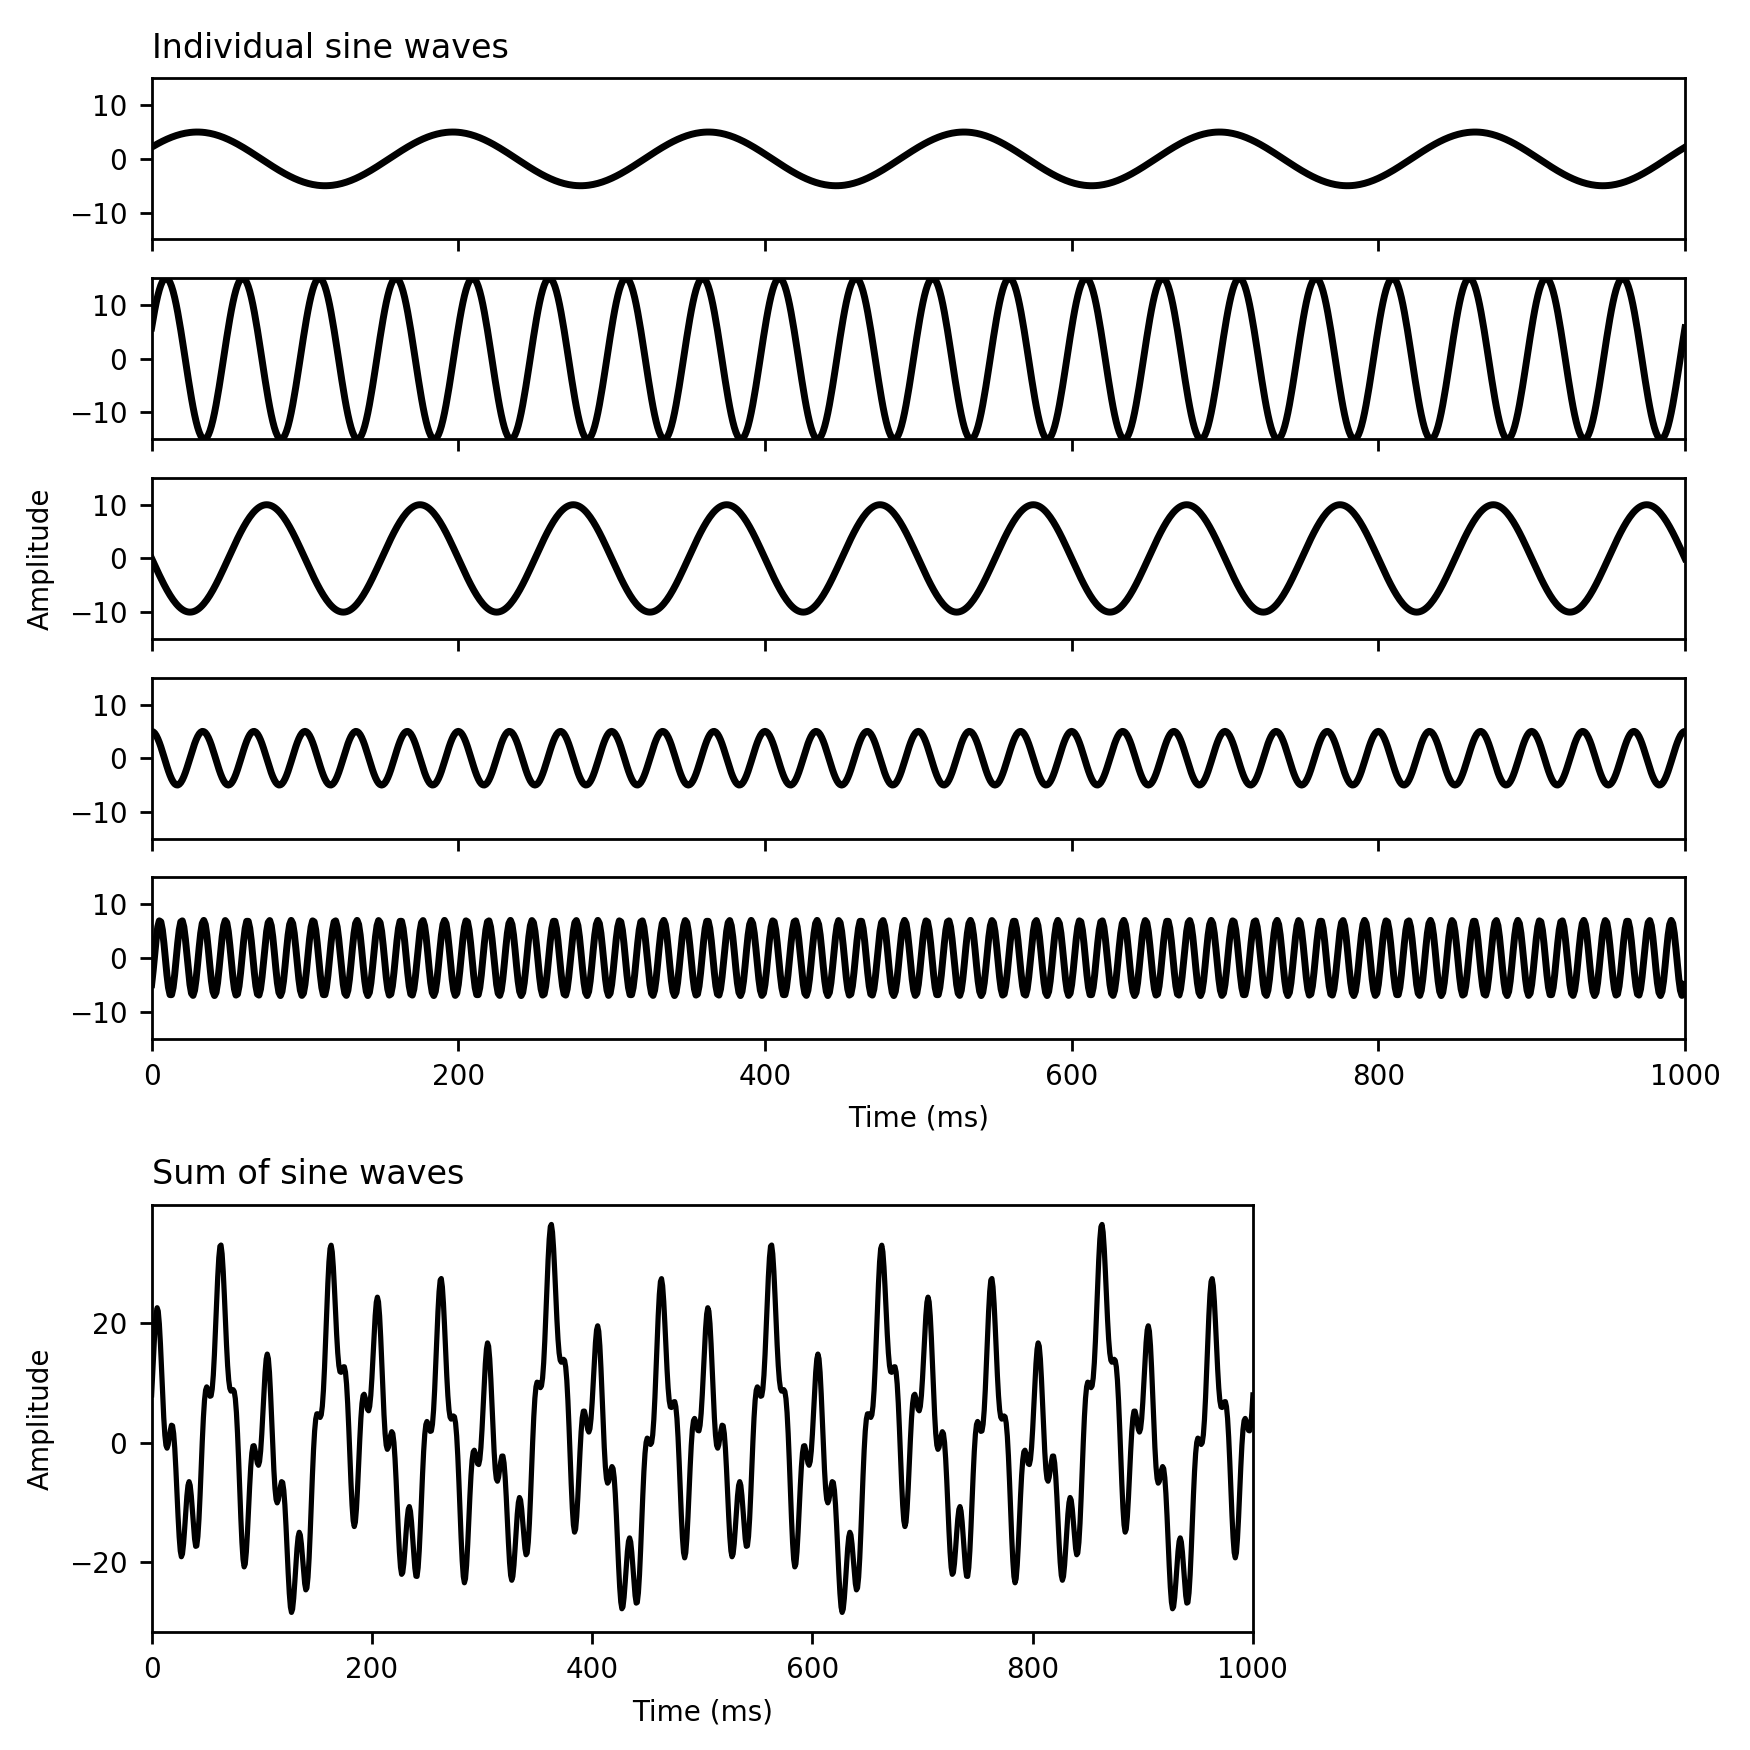

In [3]:
srate = 500
time = np.arange(-1, 1 + 1/srate, 1/srate)

# Arbitrary frequencies
freqs = np.array([3, 10, 5, 15, 35])

# Arbitrary amplitudes (same len as freqs)
amps = np.array([5, 15, 10, 5, 7])

# Arbitrary phases between -pi and pi
phases = np.array([np.pi / 7, np.pi / 8, np.pi, np.pi / 2, -np.pi / 4])

# Initialize sine waves array
sine_waves = np.zeros((len(freqs), len(time)))

# Iterate through parameters to generate different sinewaves
for i in np.arange(len(freqs)):
    sine_waves[i, :] = get_sine_wave(freqs[i], amps[i], time, phases[i])

# Figure 11.2 ----------

# Set the figure and grid
fig = plt.figure(figsize=(7, 7))
full_grid = fig.add_gridspec(2, 2, height_ratios=[2.25, 1], width_ratios=[3, 1])

# Set the subgrids
grid_A = full_grid[0, :].subgridspec(len(freqs), 1)
grid_B = full_grid[1, 0].subgridspec(1, 1)

# Add a sinewave to each row in grid A
for i in range(len(freqs)):
    ax_A = fig.add_subplot(grid_A[i, 0])
    ax_A.plot(sine_waves[i, :], linewidth=2, color='black')
    ax_A.set_xlim([0, 1000])
    ax_A.set_ylim([-np.max(amps), np.max(amps)])
    
    # Format appropriately (A pain, but as AFAICT no sharex attribute with subplot grids)
    if i == 0:
        ax_A.set_title('Individual sine waves', loc='left')
    if i == 2:
        ax_A.set_ylabel('Amplitude')
    if i == len(freqs) - 1:
        ax_A.set_xlabel('Time (ms)')
    else:
        ax_A.set_xticklabels([])

# Sum all the sine waves and plot below
ax_B = fig.add_subplot(grid_B[0, 0])
ax_B.plot(np.sum(sine_waves, axis=0), color='black')
ax_B.set_xlim([0, 1000])
ax_B.set_xlabel('Time (ms)')
ax_B.set_ylabel('Amplitude')
ax_B.set_title('Sum of sine waves', loc='left')
fig.tight_layout()

### Figure 11.3

<IPython.core.display.Javascript object>


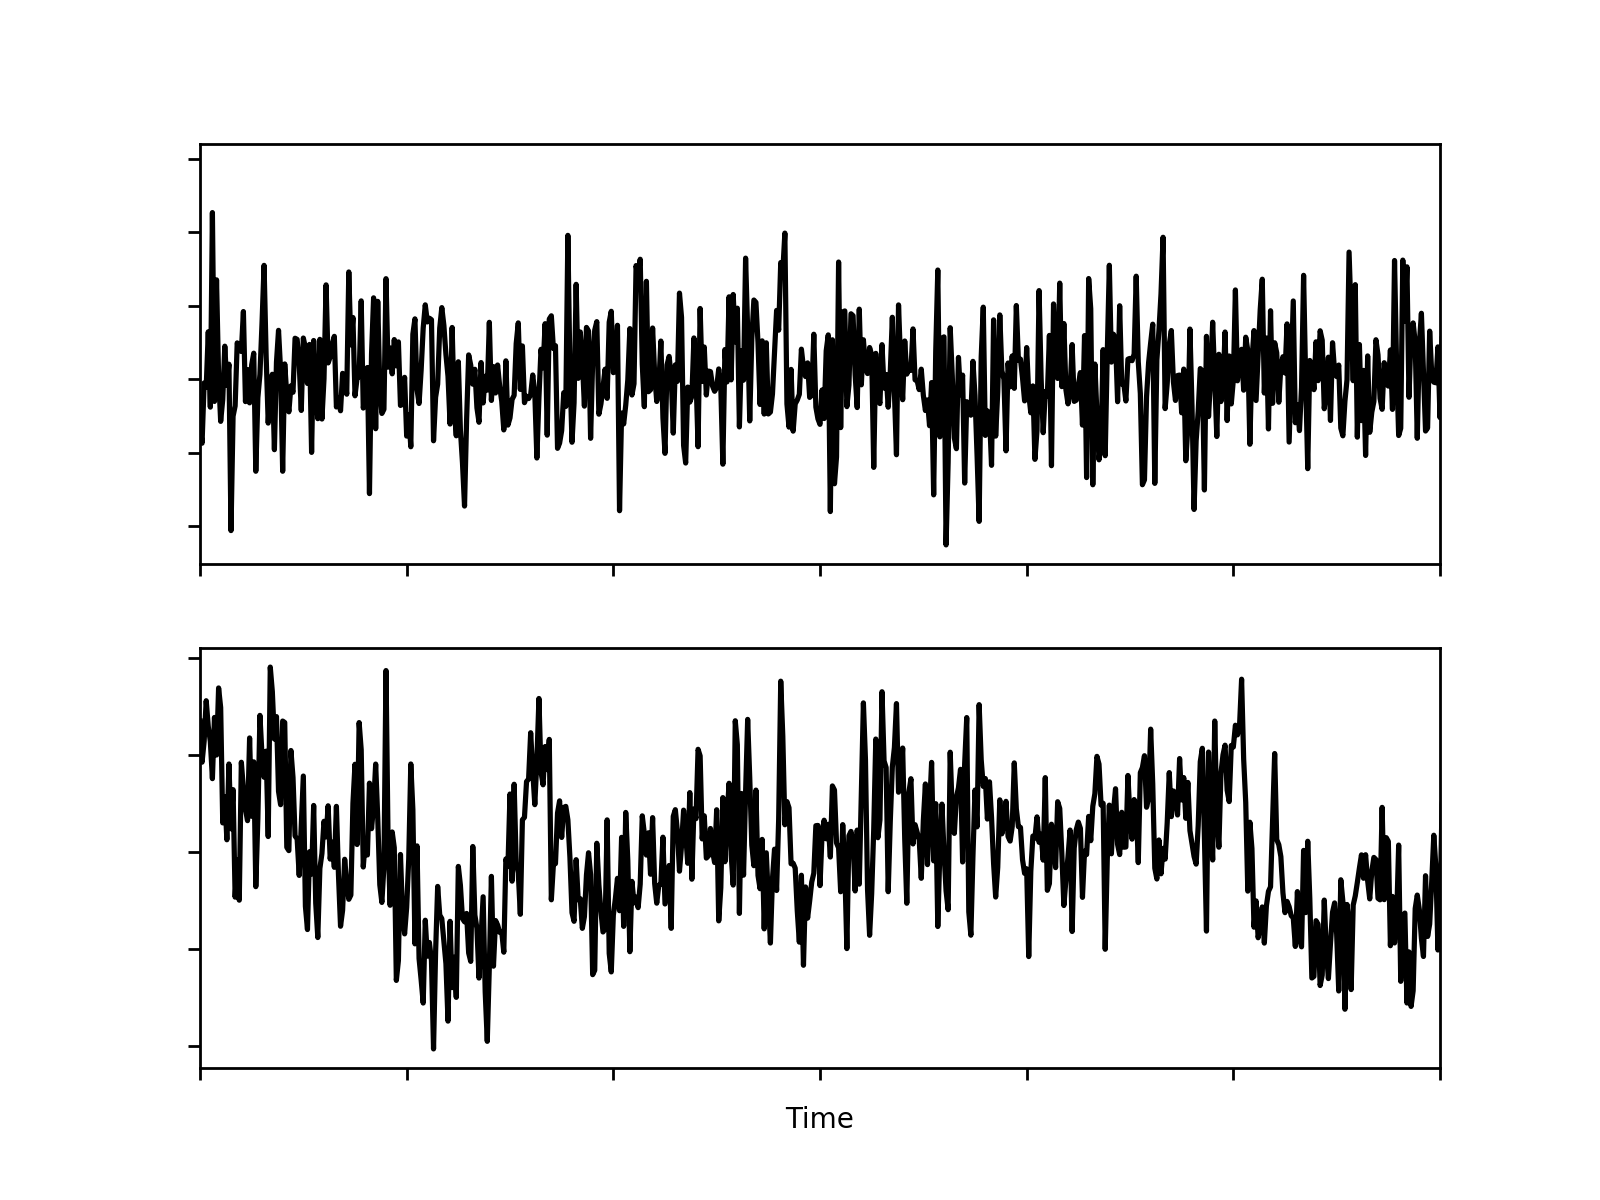

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

# Sine-waves plus Gaussian noise; top panel
ax[0].plot(np.sum(sine_waves * np.random.normal(size=sine_waves.shape), axis=0), color='black')
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])

# EEG data at index 1 channel, index 1 trial; bottom panel
ax[1].plot(eeg_data[1, :, 1], color='black')
ax[1].set_yticklabels([])

plt.xlim([0, 600])
plt.xlabel('Time')
plt.show()

### Figure 11.4

<IPython.core.display.Javascript object>


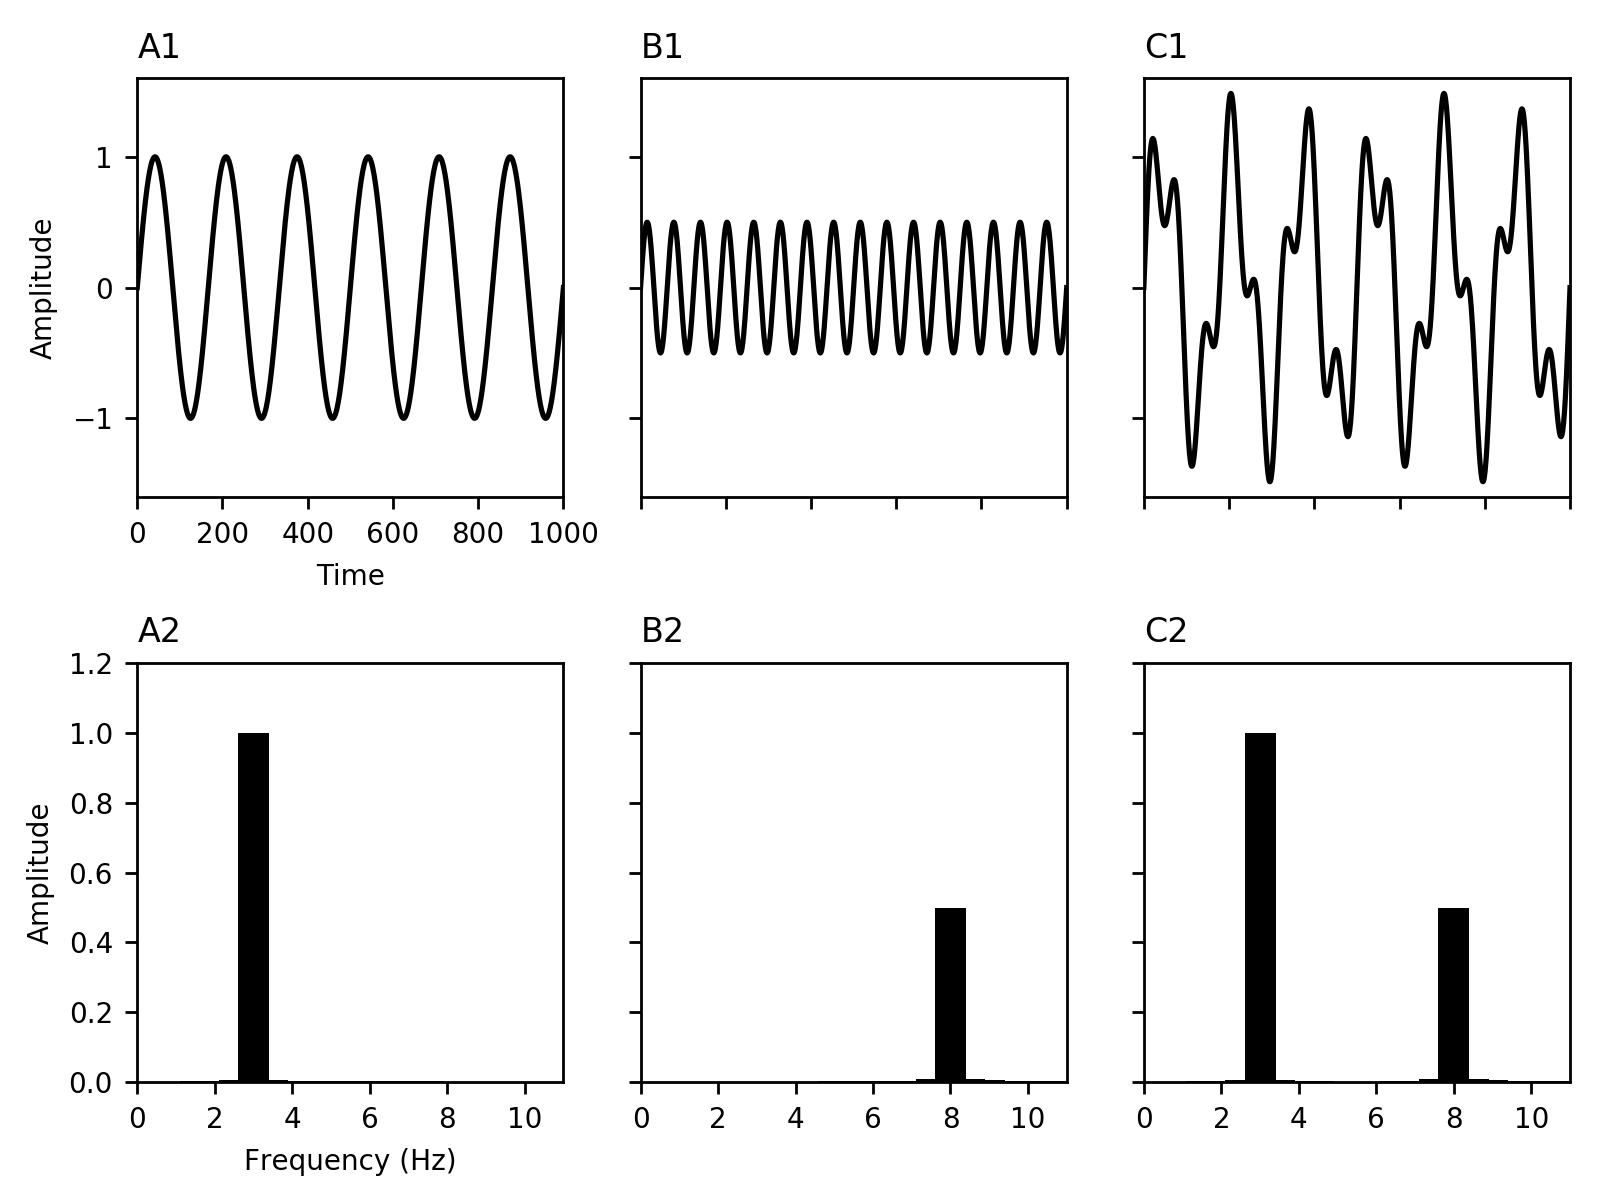

In [5]:
sine_1 = get_sine_wave(frequency=3, amplitude=1, time_vec=time)
sine_2 = get_sine_wave(frequency=8, amplitude=0.5, time_vec=time)
sine_3 = sine_1 + sine_2

# To get letters from numbers for labelling
def pos_to_char(pos):
    return chr(pos + 97).upper()

fig, ax = plt.subplots(nrows=2, ncols=3)
for i in range(3):
    # Sine waves
    sines = 'sine_' + str(i + 1)
    ax[0, i].plot(eval(sines), color='black')
    ax[0, i].set_xlim([0, 1000])
    ax[0, i].set_ylim([-1.6, 1.6])
    ax[0, i].set_yticks([-1, 0, 1])
    ax[0, i].set_title(pos_to_char(i) + str(1), loc='left')
    
    # Discrete fourier transforms
    f = np.fft.fft(eval(sines)) / len(time)
    hz = np.linspace(0, srate/2, int(np.floor(len(time) / 2) + 1))
    ax[1, i].bar(hz, height=np.abs(f[0:len(hz)] * 2), color='black')
    ax[1, i].set_xticks(np.arange(0, 11, 2))
    ax[1, i].set_xlim([0, 11])
    ax[1, i].set_ylim([0, 1.2])
    ax[1, i].set_title(pos_to_char(i) + str(2), loc='left')
    
    # Formatting axes and labels
    if i != 0:
        ax[0, i].set_xticklabels([])
        ax[0, i].set_yticklabels([])
        ax[1, i].set_yticklabels([])
    else:
        ax[0, i].set_xlabel('Time')
        ax[0, i].set_ylabel('Amplitude')
        ax[1, i].set_xlabel('Frequency (Hz)')
        ax[1, i].set_ylabel('Amplitude')

plt.tight_layout()

### Figure 11.5

In [6]:
n = 10 # Length of sequence
srate = 200 # Sampling rate in Hz
nyq = srate / 2 # Nyquist frequency, the highest measureable frequency in the data

np.random.seed(99) # Set seed for the random number generator, to ensure behaved phase values
data = np.random.normal(size=n) # Random numbers from a normal distribution

# Initialize Fourier output matrix
fourier_unscaled = np.zeros(data.shape, dtype=complex)

# These are the actual frequencies in Hz that will be returned by the Fourier transform. The number of unique 
# frequencies we can measure is exactly 1/2 of the number of data points in the time series (plus DC).
freqs = np.linspace(0, nyq, int(n / 2 + 1))
time = (np.arange(1, n + 1) - 1) / n

# The Fourier transform is the dot product between the sine wave and data at each frequency
for i in range(n):
    sine_wave = np.exp(-1j * 2 * np.pi * i * time)
    fourier_unscaled[i] = np.dot(sine_wave, data)

<IPython.core.display.Javascript object>


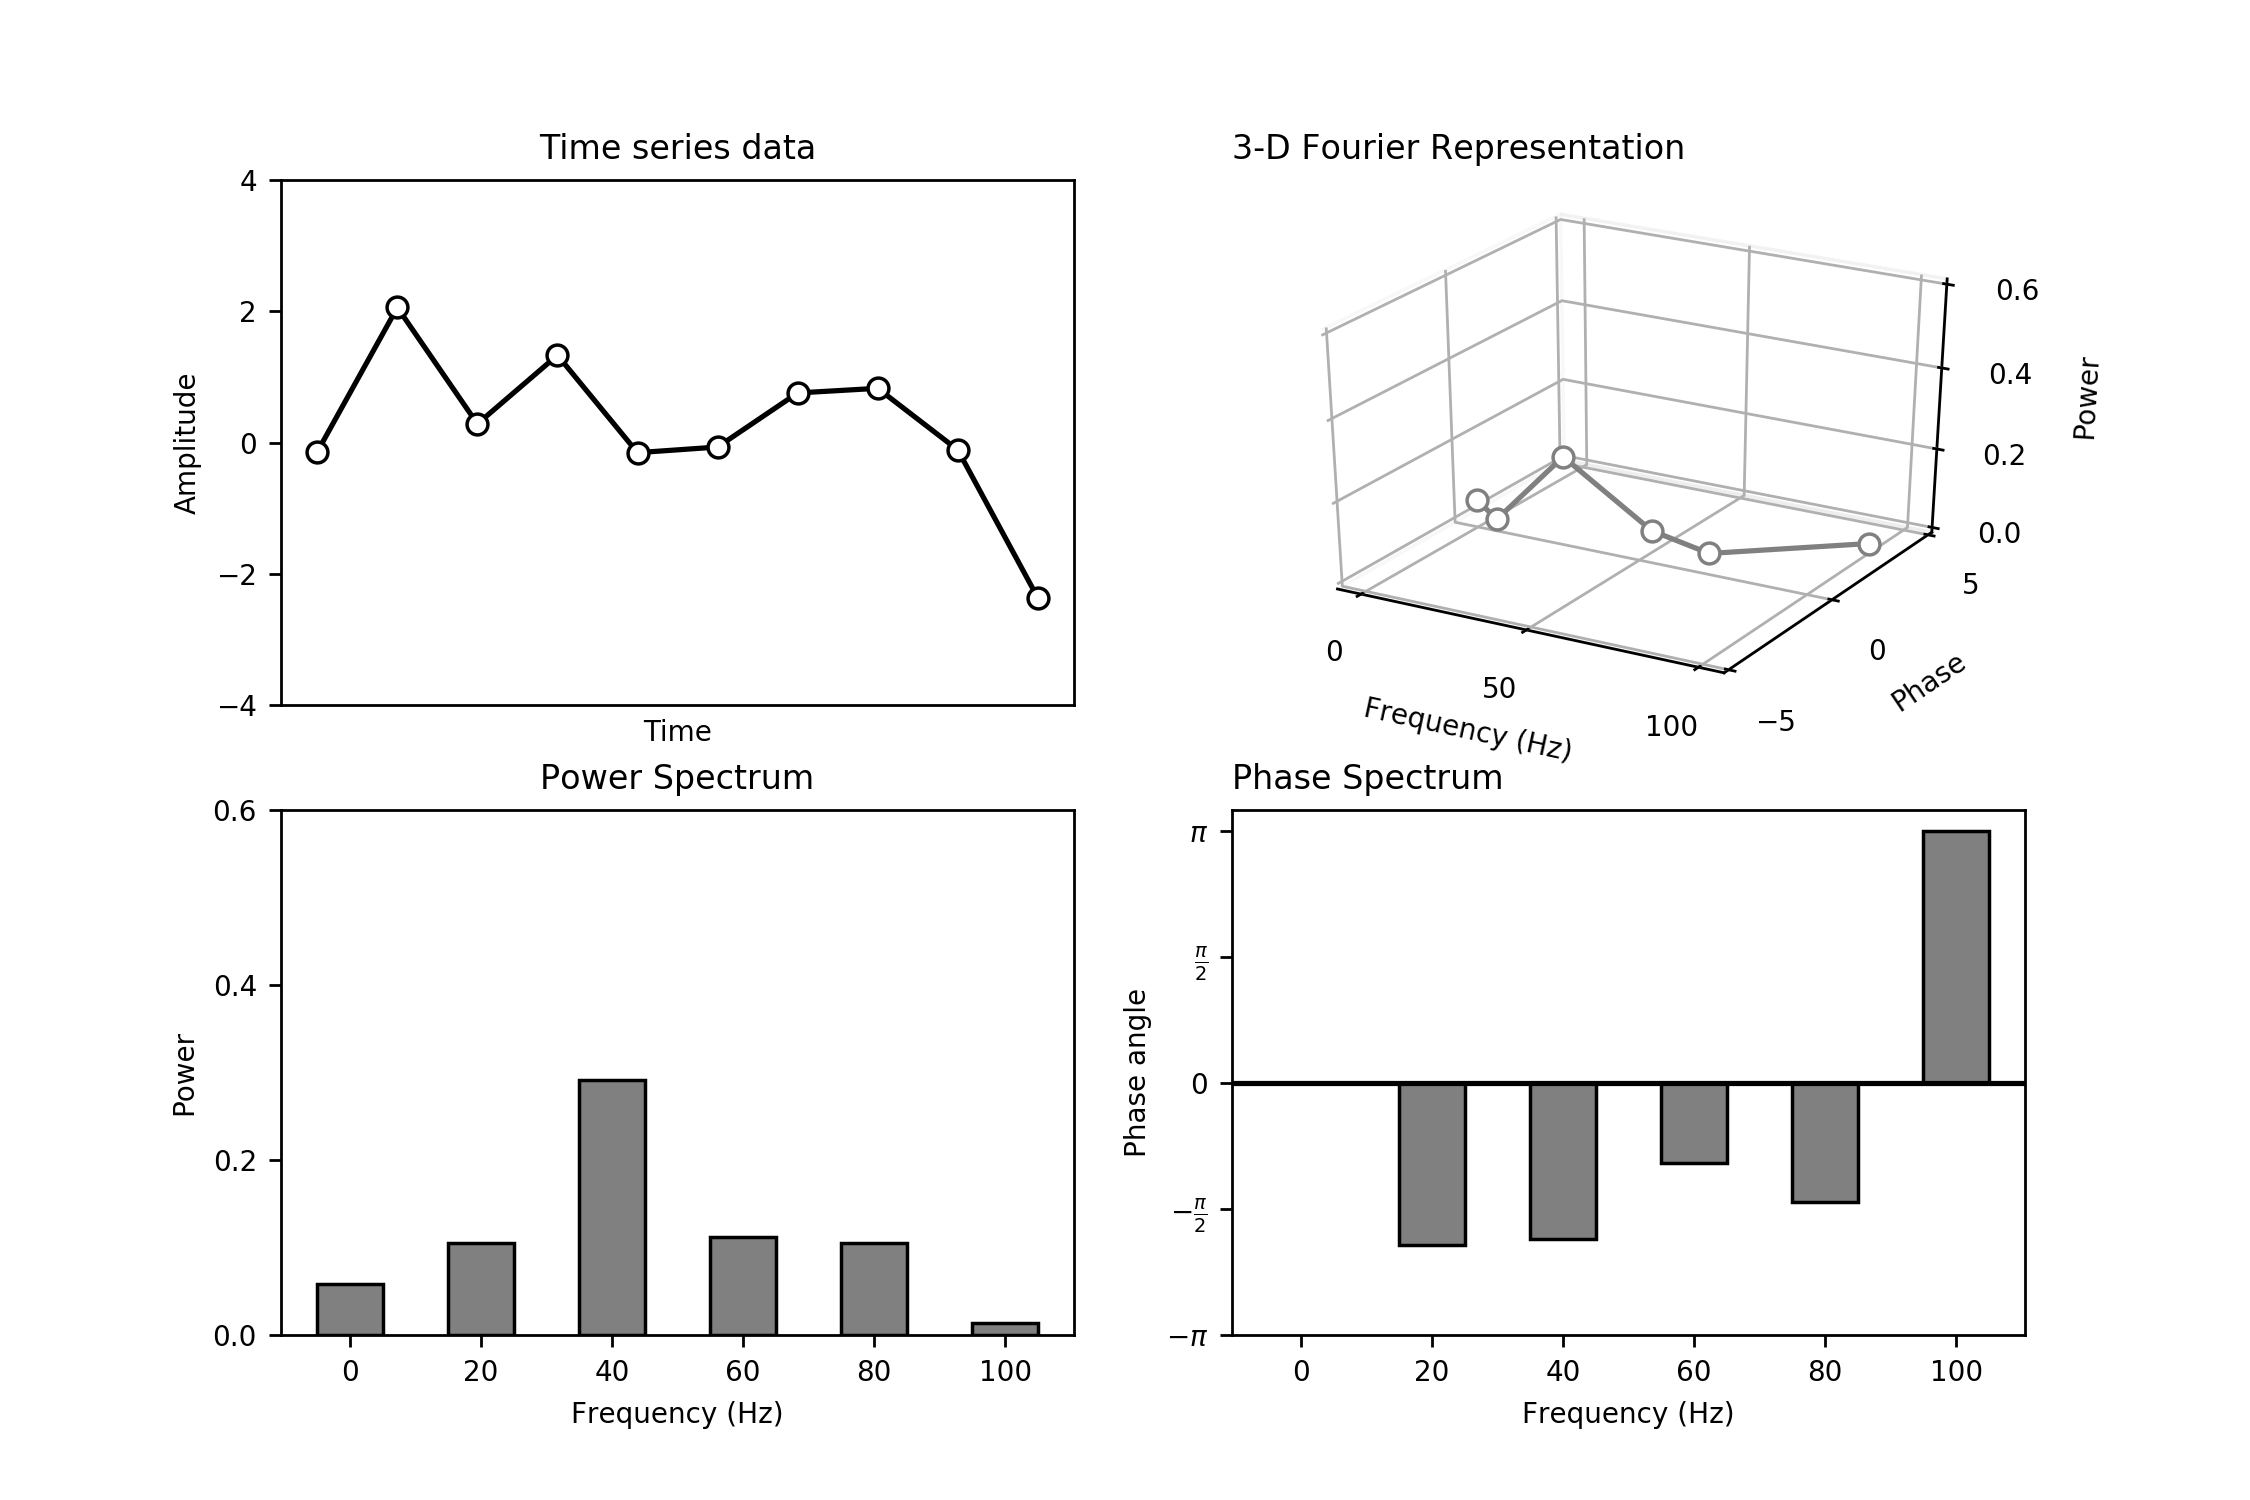

In [7]:
fourier = fourier_unscaled / n
ft_idx = np.arange(0, int(n / 2) + 1)
man_power = np.abs(fourier[ft_idx]) ** 2
man_phase = np.angle(fourier[ft_idx], deg=False)

# Figure 11.5 ----------

fig = plt.figure(figsize=(9, 6))

# Time series
ax_1 = plt.subplot(2, 2, 1)
ax_1.plot(data, color='black', marker='o', markerfacecolor='white')
ax_1.set_xticks([])
ax_1.set_yticks(np.arange(-4, 5, 2))
ax_1.set_ylim([-4, 4])
ax_1.set_xlabel('Time')
ax_1.set_ylabel('Amplitude')
ax_1.set_title('Time series data')

ax_2 = plt.subplot(2, 2, 2, projection='3d')
ax_2.plot3D(freqs, man_phase, man_power, color='gray', marker='o', markerfacecolor='white')
ax_2.set_xticks(np.linspace(0, 100, 3))
ax_2.set_yticks(np.linspace(-5, 5, 3))
ax_2.set_zticks(np.linspace(0, .6, 4))
ax_2.set_xlabel('Frequency (Hz)')
ax_2.set_ylabel('Phase')
ax_2.set_zlabel('Power')
ax_2.set_title('3-D Fourier Representation', loc='left')
ax_2.xaxis.pane.fill = False
ax_2.yaxis.pane.fill = False
ax_2.zaxis.pane.fill = False

ax_3 = plt.subplot(2, 2, 3)
ax_3.bar(freqs, height=man_power, width=10, color='grey', edgecolor='black')
ax_3.set_xticks(np.linspace(0, 100, 6))
ax_3.set_yticks(np.linspace(0, .6, 4))
ax_3.set_xlabel('Frequency (Hz)')
ax_3.set_ylabel('Power')
ax_3.set_title('Power Spectrum')

ax_4 = plt.subplot(2, 2, 4)
ax_4.bar(freqs, height=man_phase, width=10, color='grey', edgecolor='black')
ax_4.axhline(color='black')
ax_4.set_yticks(np.arange(-np.pi, np.pi + 1, np.pi / 2))
ax_4.set_yticklabels((r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$', r'$\pi$'))
ax_4.set_xlabel('Frequency (Hz)')
ax_4.set_ylabel('Phase angle')
ax_4.set_title('Phase Spectrum', loc='left')

plt.show()

### Figure 11.6

<IPython.core.display.Javascript object>


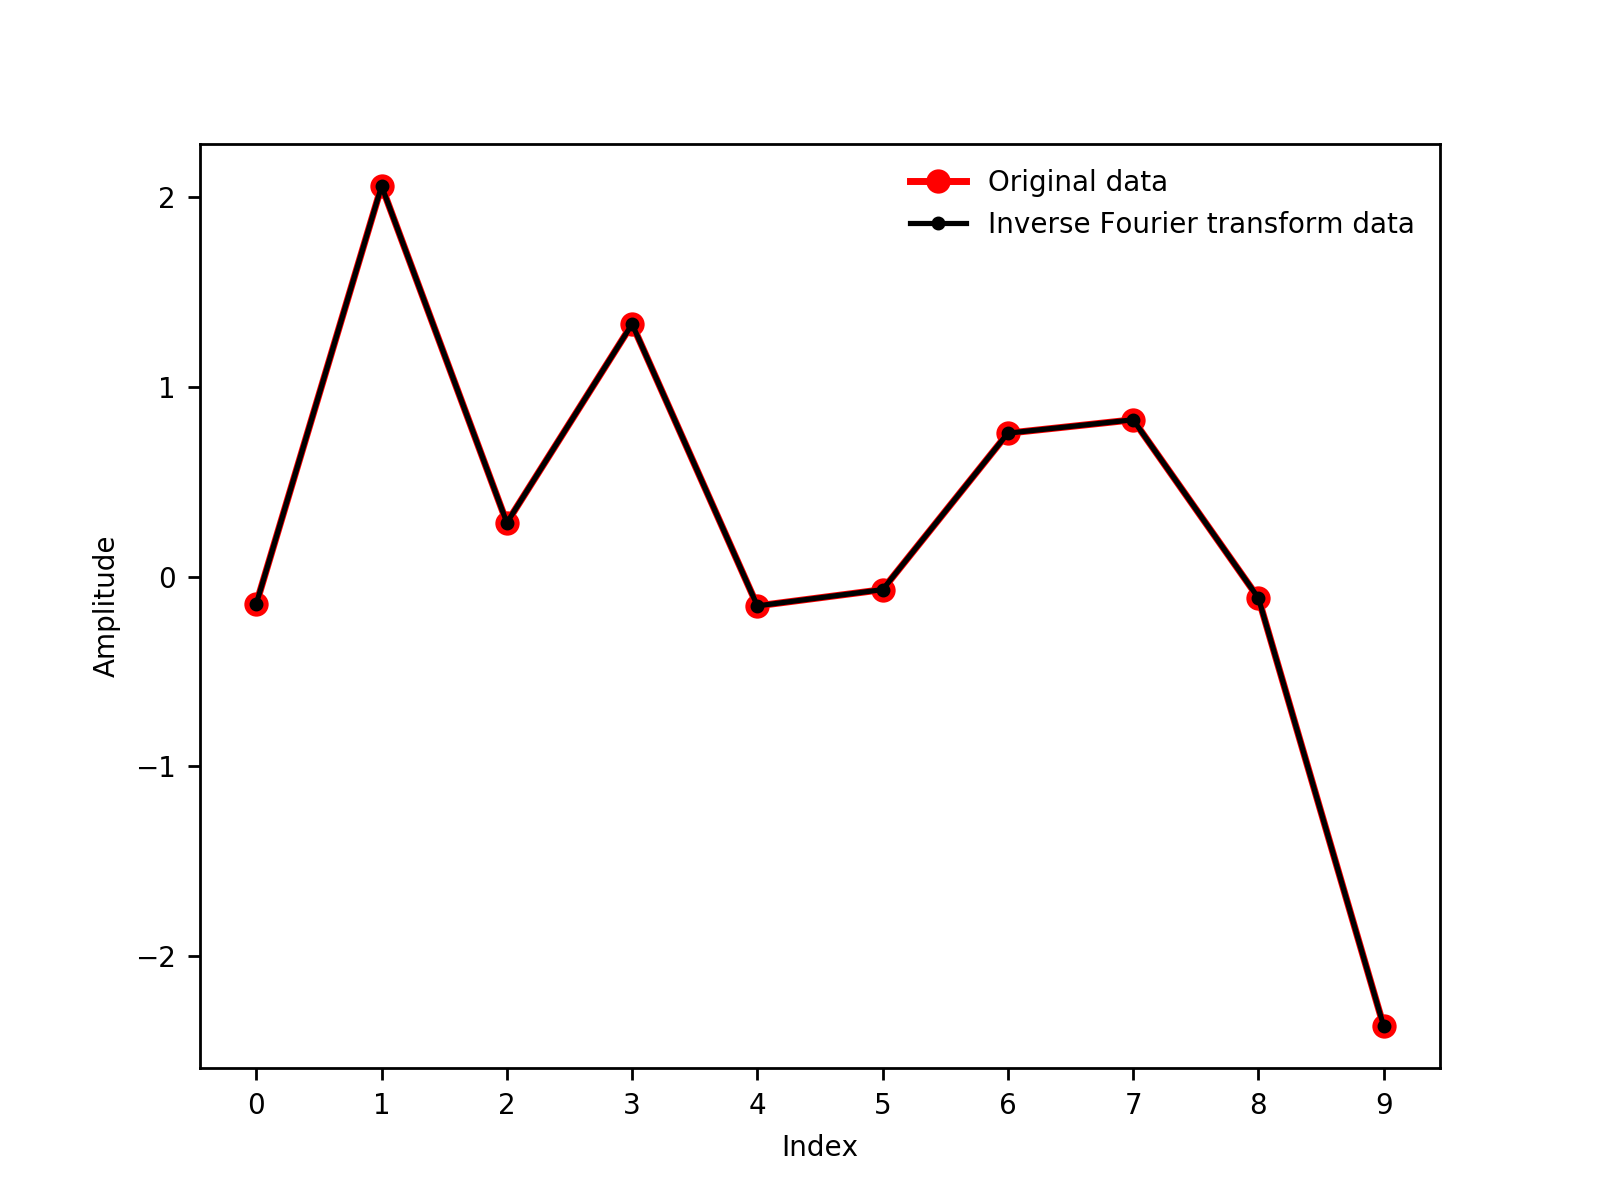

In [8]:
# Compute sine waves and sum to recover the original time series
reconstruct_data = np.zeros(data.shape)

for i in range(n):
    # Scale sine wave by Fourier coefficient
    sine_wave = fourier[i] * np.exp(1j * 2 * np.pi * i * time)
    # Sum sine waves together (take only real part)
    reconstruct_data = reconstruct_data + np.real(sine_wave)

plt.figure()
plt.plot(data, color='red', marker='o', linewidth=2)
plt.plot(reconstruct_data, color='black', marker='.')
plt.yticks(np.linspace(-2, 2, 5))
plt.xticks(np.arange(0, 10))
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.legend(labels=('Original data', 'Inverse Fourier transform data'), frameon=False)
plt.show()

### Figure 11.7

<IPython.core.display.Javascript object>


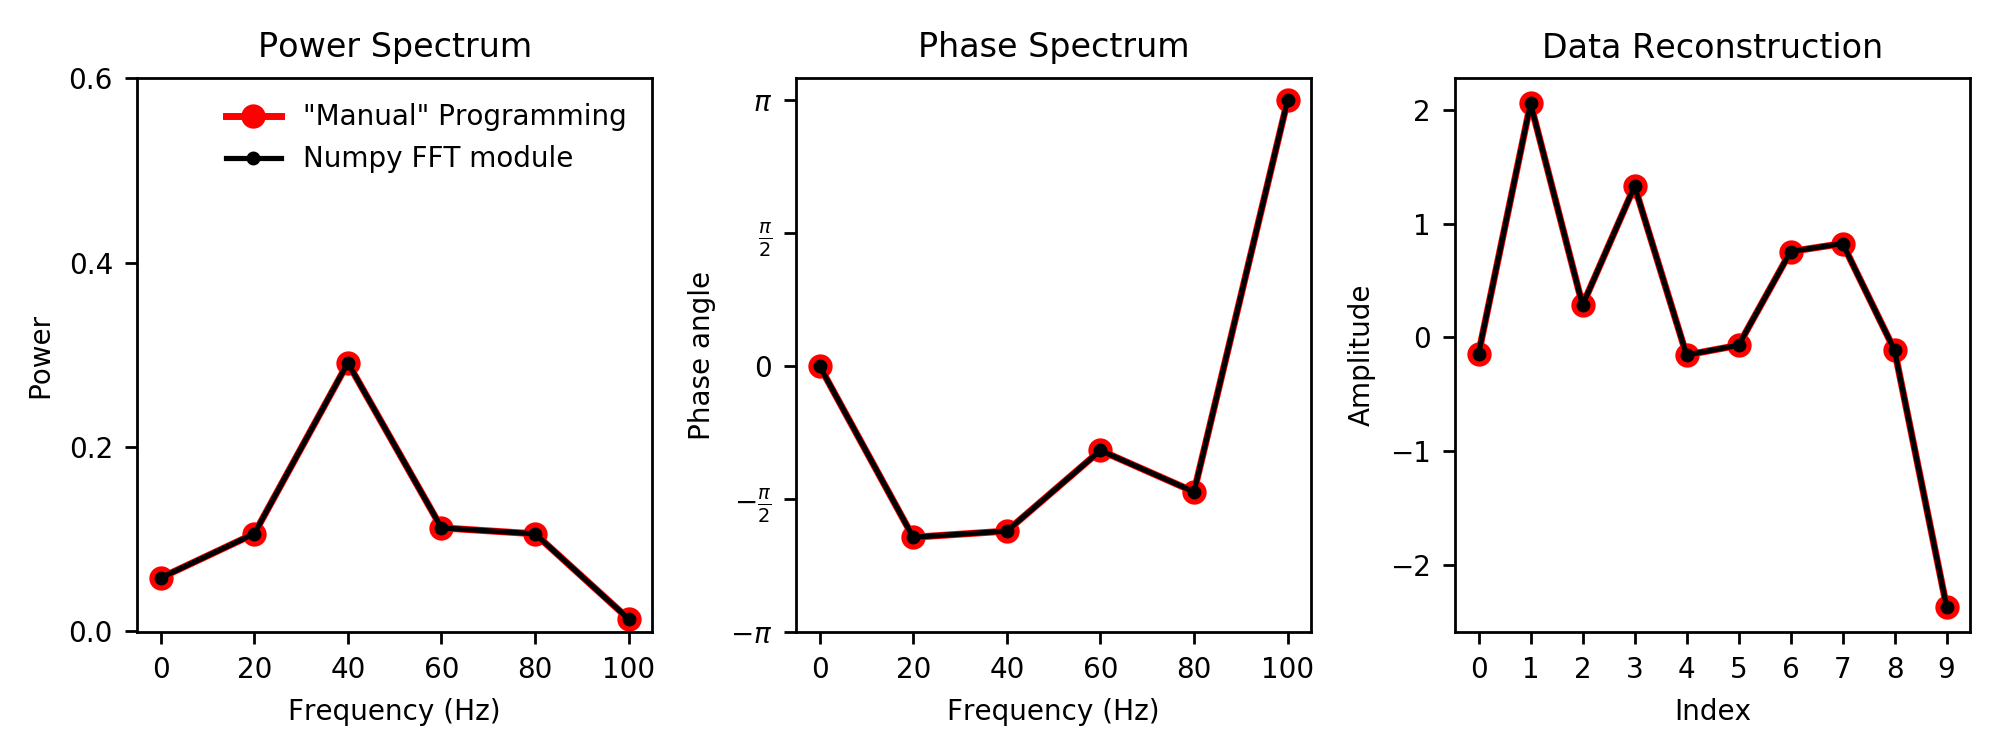

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [9]:
# Use numpy to compute the fast Fourier transform
fft_data = np.fft.fft(data) / n
fft_power = np.abs(fft_data[ft_idx]) ** 2
fft_phase = np.angle(fft_data[ft_idx], deg=False)
ifft_data = np.fft.ifft(np.fft.fft(data))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

ax[0].plot(freqs, man_power, color='red', marker='o', linewidth=2)
ax[0].plot(freqs, fft_power, color='black', marker='.')
ax[0].set_xticks(np.linspace(0, 100, 6))
ax[0].set_yticks(np.linspace(0, .6, 4))
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Power')
ax[0].set_title('Power Spectrum')
ax[0].legend(labels=('"Manual" Programming', 'Numpy FFT module'), frameon=False)

# Note that if you see differences across the two methods for the phase
# either at 0 / 2 pi or at - pi / pi, that's ok! It's due to small rounding errors.
# This is why I set the seed when we generated the data to ensure well-behaved phase values.
ax[1].plot(freqs, man_phase, color='red', marker='o', linewidth=2)
ax[1].plot(freqs, fft_phase, color='black', marker='.')
ax[1].set_yticks(np.arange(-np.pi, np.pi + 1, np.pi / 2))
ax[1].set_yticklabels((r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$', r'$\pi$'))
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Phase angle')
ax[1].set_title('Phase Spectrum')


ax[2].plot(ifft_data, color='red', marker='o', linewidth=2)
ax[2].plot(reconstruct_data, color='black', marker='.')
ax[2].set_yticks(np.linspace(-2, 2, 5))
ax[2].set_xticks(np.arange(0, 10))
ax[2].set_xlabel('Index')
ax[2].set_ylabel('Amplitude')
ax[2].set_title('Data Reconstruction')

fig.tight_layout()

### Figure 11.9

<IPython.core.display.Javascript object>


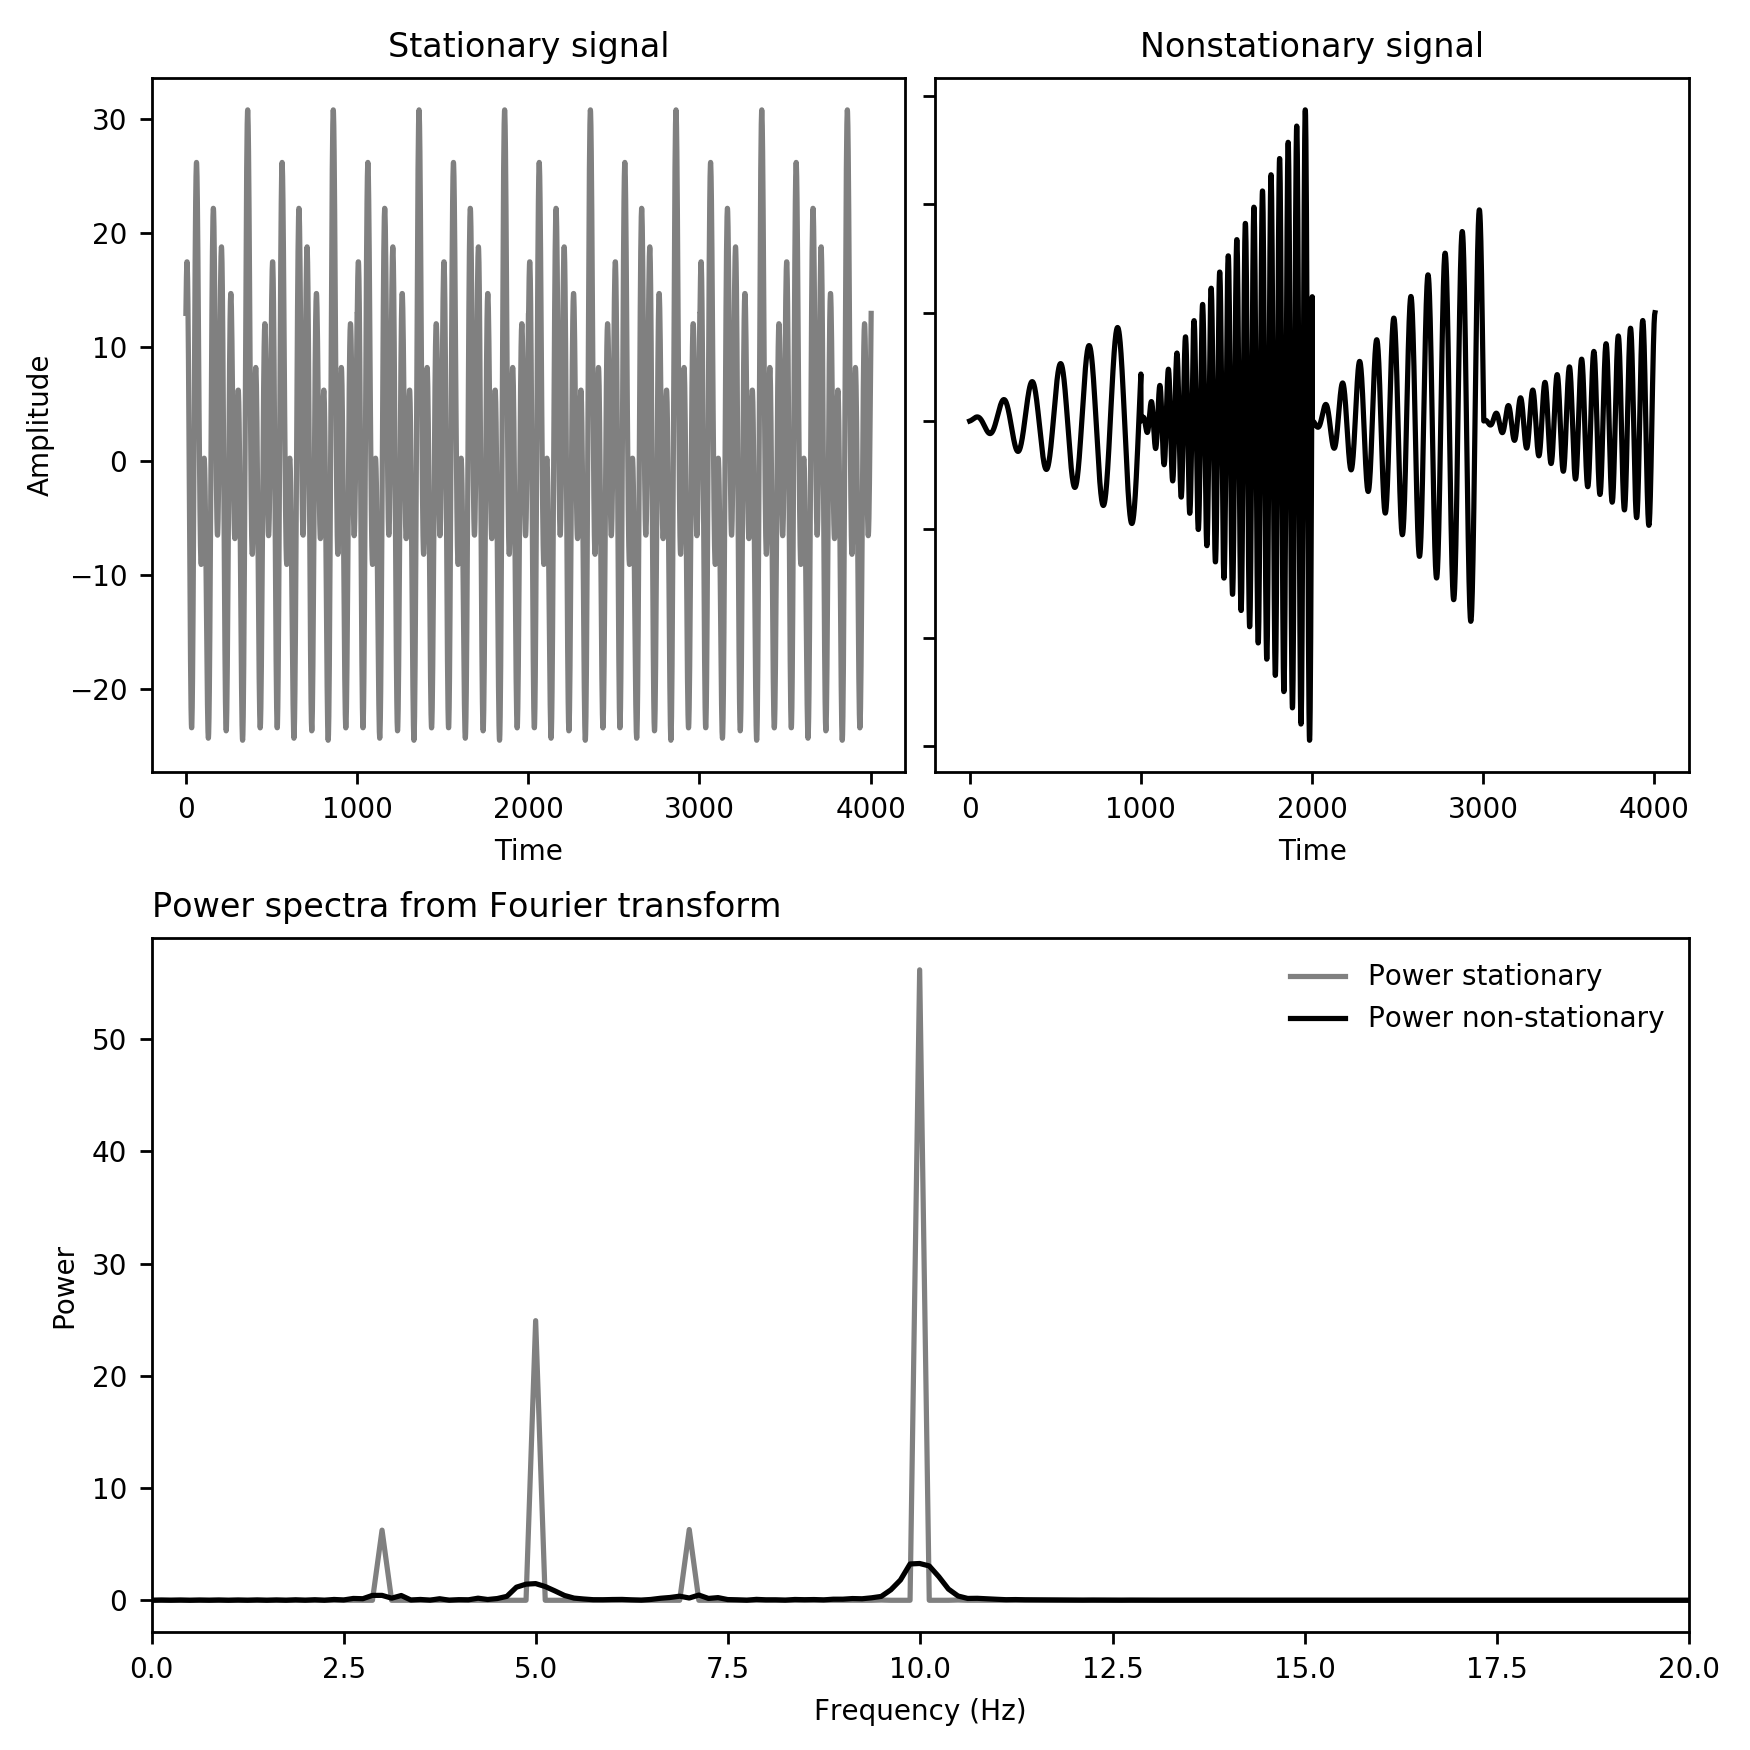

In [10]:
srate = 500 # sampling rate in Hz
time = np.arange(-1, 1 + 1/srate, 1/srate)

# Arbitrary frequencies
freqs = np.array([3, 10, 5, 7])

# Arbitrary amplitudes (same len as freqs)
amps = np.array([5, 15, 10, 5])

# Arbitrary phases between -pi and pi
phases = np.array([np.pi / 7, np.pi / 8, np.pi, np.pi / 2])

# Initialize a stationary and non-stationary time series
stationary = np.zeros(len(time) * len(freqs))
nonstationary = np.zeros(len(time) * len(freqs))

for i in np.arange(len(freqs)):
    
    # Compute sine_wave
    temp_sine_wave = get_sine_wave(frequency=freqs[i], amplitude=amps[i], time_vec=time, phase=phases[i])
    
    # Enter into stationary time series
    stationary = stationary + np.tile(temp_sine_wave, (1, len(freqs)))
    
    # Optional change of amplitude over time
    temp_sine_wave = temp_sine_wave * (time + 1)
    
    # Determine start and stop indices for insertion of sine waves
    start_idx = i * len(time)
    stop_idx = i * len(time) + len(time)
    
    # Enter into non-stationary time series
    nonstationary[start_idx:stop_idx] = temp_sine_wave

stationary_pwr, frequencies = compute_power(stationary[0], srate)
nonstationary_pwr, frequencies = compute_power(nonstationary, srate)

# Figure 11.9 ----------

# Set the figure and grid
fig = plt.figure(figsize=(7, 7))
full_grid = fig.add_gridspec(2, 2)

# Set the subgrids
grid_A = full_grid[0, :].subgridspec(1, 2)
grid_B = full_grid[1, :].subgridspec(1, 1)

# Stationary
ax_A00 = fig.add_subplot(grid_A[0, 0])
ax_A00.plot(stationary[0], color='grey')
ax_A00.set_xticks(np.linspace(0, 4000, 5))
ax_A00.set_xlabel('Time')
ax_A00.set_ylabel('Amplitude')
ax_A00.set_title('Stationary signal')

# Non-stationary
ax_A01 = fig.add_subplot(grid_A[0, 1])
ax_A01.plot(nonstationary, color='black')
ax_A01.set_xticks(np.linspace(0, 4000, 5))
ax_A01.set_yticklabels([])
ax_A01.set_xlabel('Time')
ax_A01.set_title('Nonstationary signal')

ax_B = fig.add_subplot(grid_B[0, 0])
ax_B.plot(frequencies, stationary_pwr, color='grey')
ax_B.plot(frequencies, nonstationary_pwr, color='black')
ax_B.set_xlim([0, np.max(freqs) * 2])
ax_B.set_xlabel('Frequency (Hz)')
ax_B.set_ylabel('Power')
ax_B.set_title('Power spectra from Fourier transform', loc='left')
ax_B.legend(labels=('Power stationary', 'Power non-stationary'), frameon=False)

fig.tight_layout()

### Figure 11.10

<IPython.core.display.Javascript object>


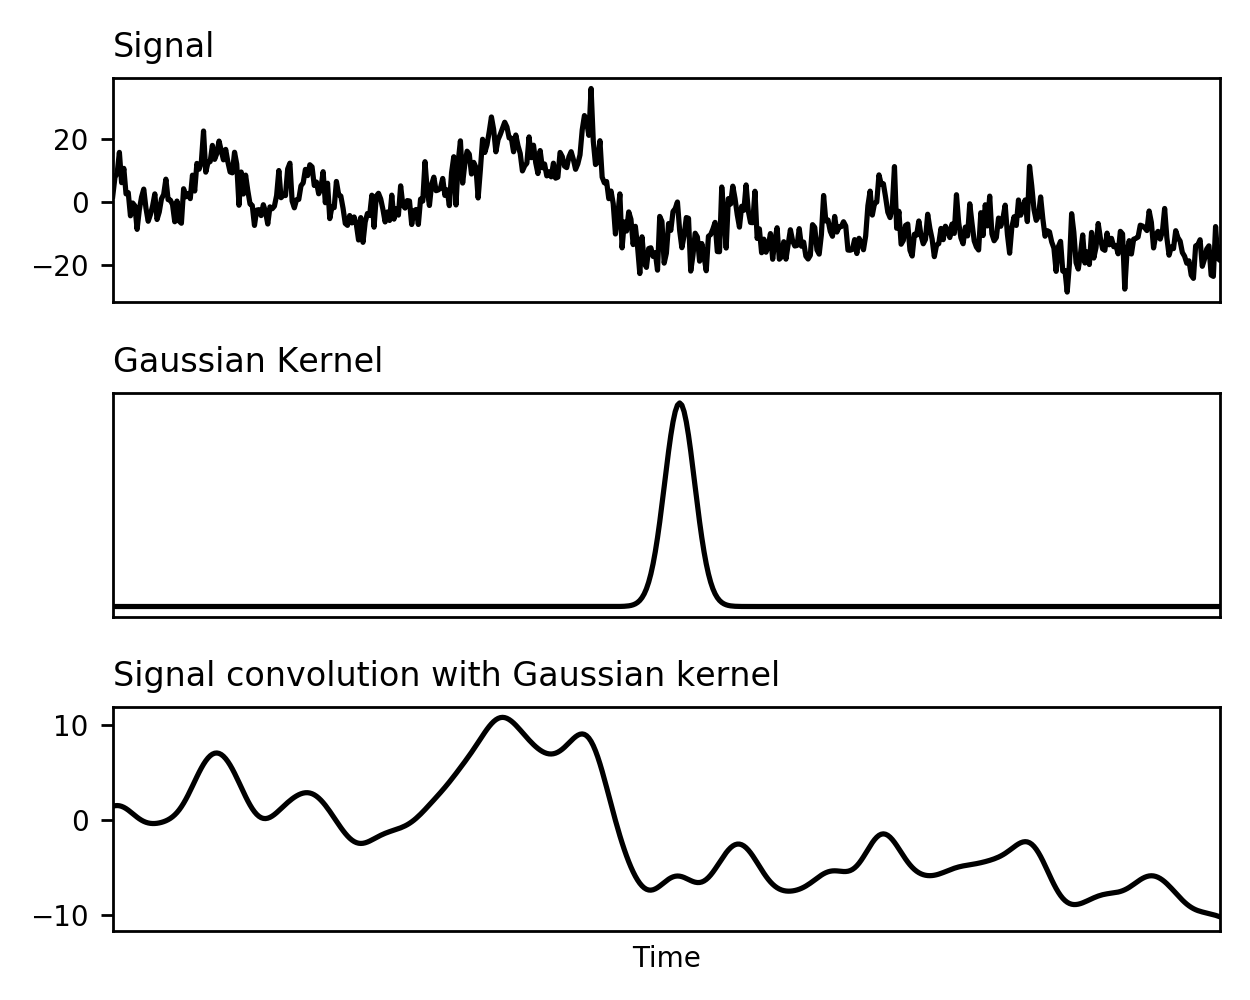

In [11]:
eeg_data_for_conv = np.squeeze(eeg_data[46, :, 0])

time = np.arange(-1, 1 + 1 / info['sfreq'], 1 / info['sfreq'])
s = 5 / (2 * np.pi * 30)
gaussian = np.exp((-time ** 2) / (2 * s ** 2)) / 30

# Convole data with Gaussian kernel
conv_data = np.convolve(eeg_data_for_conv, gaussian, 'same')

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(5, 4))

ax[0].plot(eeg_data_for_conv, color='black')
ax[0].set_title('Signal', loc='left')

ax[1].plot(gaussian, color='black')
ax[1].set_xlim([0, 500])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Gaussian Kernel', loc='left')

ax[2].plot(conv_data, color='black')
ax[2].set_xlabel('Time')
ax[2].set_title('Signal convolution with Gaussian kernel', loc='left')

fig.tight_layout()

<IPython.core.display.Javascript object>


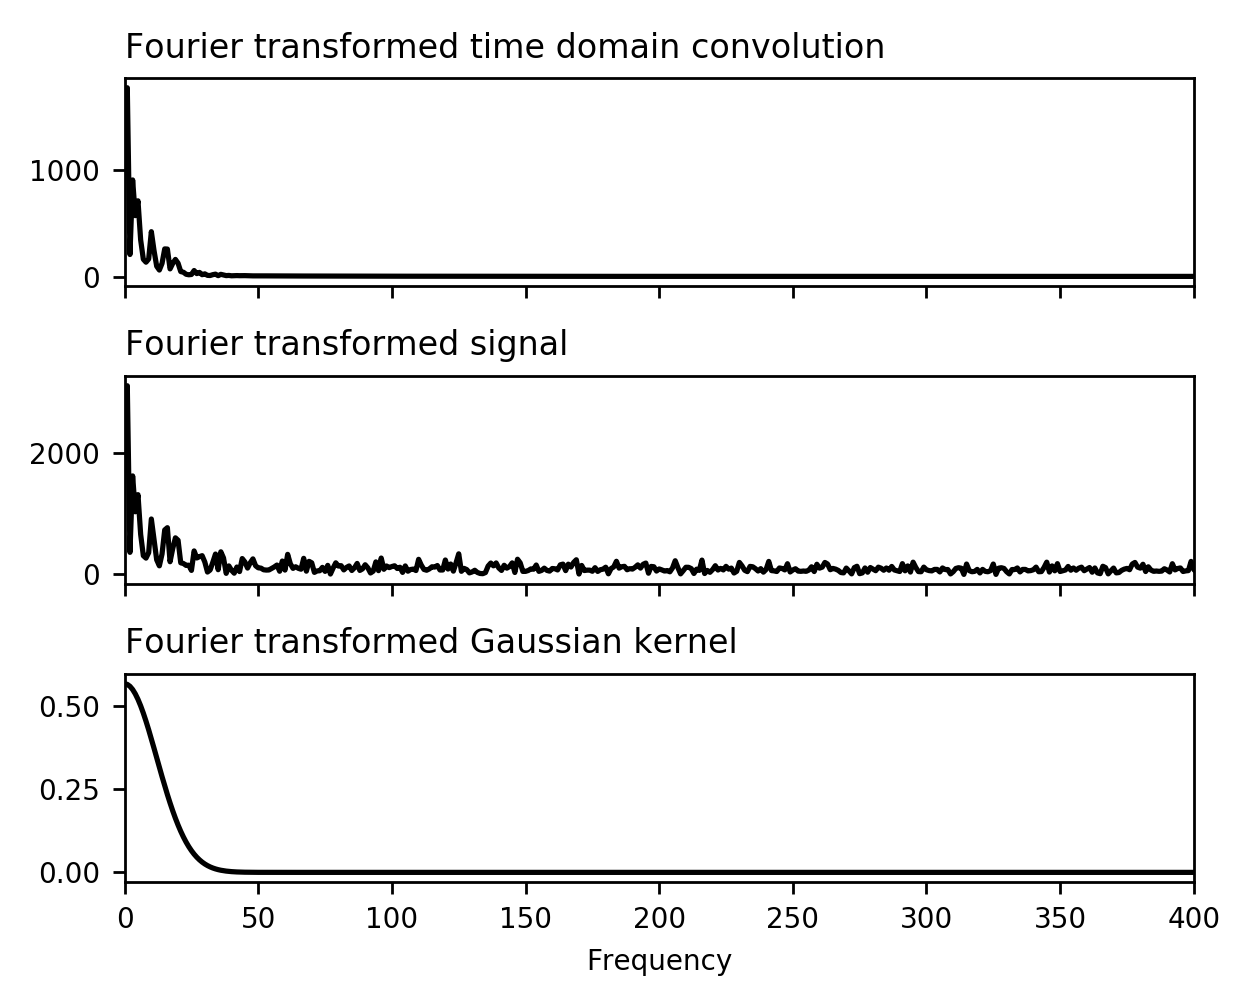

In [12]:
# Fourier transform convolved data
fft_conv = np.abs(np.fft.fft(conv_data))

# Fourier transform w/o convolution
fft_data = np.abs(np.fft.fft(eeg_data_for_conv))

# Fourier transform Gaussian kernel
fft_gauss = np.abs(np.fft.fft(gaussian))

fig, ax = plt.subplots(nrows=3,ncols=1, figsize = (5, 4), sharex=True)

ax[0].plot(fft_conv, color='black')
ax[0].set_title('Fourier transformed time domain convolution', loc='left')

ax[1].plot(fft_data, color='black')
ax[1].set_title('Fourier transformed signal', loc='left')

ax[2].plot(fft_gauss, color='black')
ax[2].set_xlabel('Frequency')
ax[2].set_xlim([0, 400])
ax[2].set_title('Fourier transformed Gaussian kernel', loc='left')

fig.tight_layout()

### Figure 11.11

### Figure 11.12